### Discovery of interesting peak-gene pairs

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import anndata as ad
from bs4 import BeautifulSoup

In [3]:
# load data
rna_adata = ad.read_h5ad('./data/rna.h5ad')
atac_adata = ad.read_h5ad('./data/atac.h5ad')

#### Prior knowledge validation

Based on prior heart studies in mice, we expect to see:
- Periostin (Postn) expression to increase with TAC and decrease with TAC+JQ1
- MEOX1 expression to increase with TAC and decrease with TAC+JQ1
- MEOX1 peaks to increase with TAC and decrease with TAC+JQ1
  - This data is human so peaks will likely not be 1:1 with mice data

In [29]:
# boxplot of expression over organ/condition
def plot_expression(adata: ad.AnnData, gene: str, layer: str = None, **kwargs) -> plt.Axes:
  gene_rna_adata = adata[:, adata.var['gene'] == gene]
  ax = sns.boxplot(gene_rna_adata.obs, x = 'organ', y = gene_rna_adata.to_df(layer = layer).sum(axis = 1), order=markers.keys(), hue = 'condition', palette=palette, hue_order = palette.keys(), **kwargs)
  ax.set_ylabel(f'{gene} expression {layer if layer is not None else ""}')
  return ax

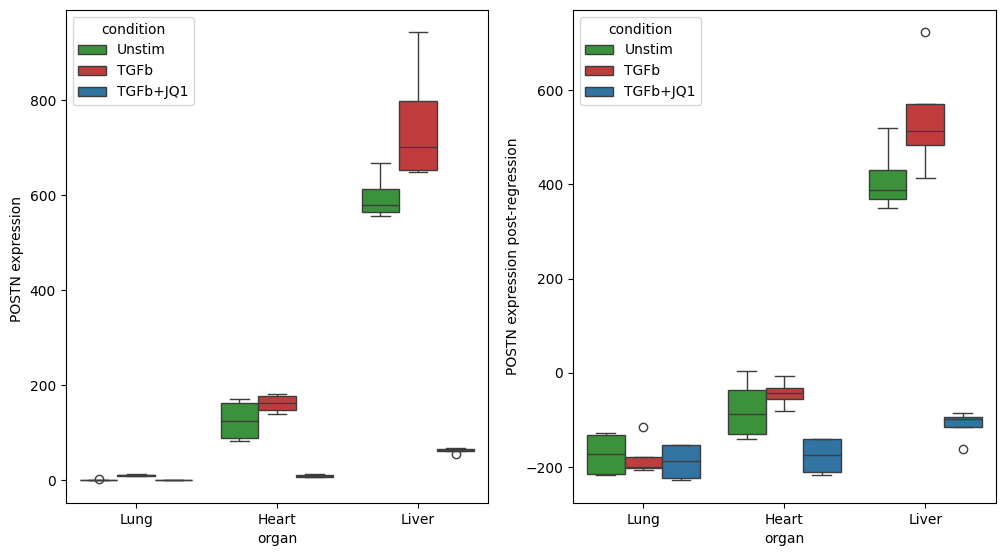

In [30]:
# Periostin expression pre- and post-regression
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, gene = 'POSTN', ax=ax1)
plot_expression(rna_adata, gene = 'POSTN', layer = 'post-regression', ax=ax2)
plt.show()

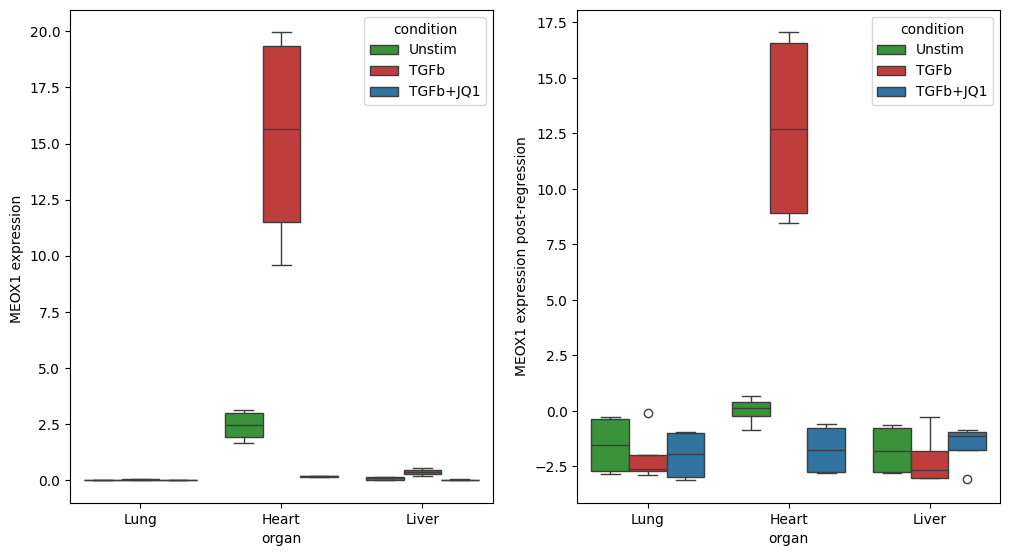

In [31]:
# MEOX1 expression
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, gene = 'MEOX1', ax=ax1)
plot_expression(rna_adata, gene = 'MEOX1', layer = 'post-regression', ax=ax2)
plt.show()

In [32]:
# heatmap of atac peaks over location range. also boxes the (approximate) gene open reading frame
def plot_peak_range(adata: ad.AnnData, chr: int, orf: tuple[float, float], layer: str = None, range = 1.5 * 10 ** 5, **kwargs) -> plt.Axes:
  orf = (orf[0] * 10 ** 6, orf[1] * 10 ** 6)
  peak_adata = adata[:, (adata.var['Chr'] == f'chr{chr}') & (adata.var['Start'] >= orf[0] - range) & (adata.var['Start'] <= orf[1] + range)]
  peak_heatmap_df = pd.DataFrame({
    f"{organ}-{condition}": {
      peak: np.mean(peak_adata[rows.index, peak]._get_X(layer = layer)) for peak in peak_adata.var_names
    }
    for (organ, condition), rows in peak_adata.obs.groupby(['organ', 'condition'])
  }, dtype = 'float64')
  peak_heatmap_df = peak_heatmap_df[[f"{organ}-{condition}" for organ in markers.keys() for condition in palette.keys()]]
  ax = sns.heatmap(peak_heatmap_df, cmap = 'viridis', **kwargs)
  ax.set_ylabel("Peak")
  ax.set_xlabel("Organ-Condition")
  coding_index = peak_adata[:, (peak_adata.var['Start'] >= orf[0]) & (peak_adata.var['Start'] <= orf[1])].var_names
  ax.add_patch(plt.Rectangle((0, peak_heatmap_df.index.get_loc(coding_index[0])), len(peak_heatmap_df.columns), len(coding_index), fill=False, edgecolor='crimson', lw=2, clip_on=False))
  return ax

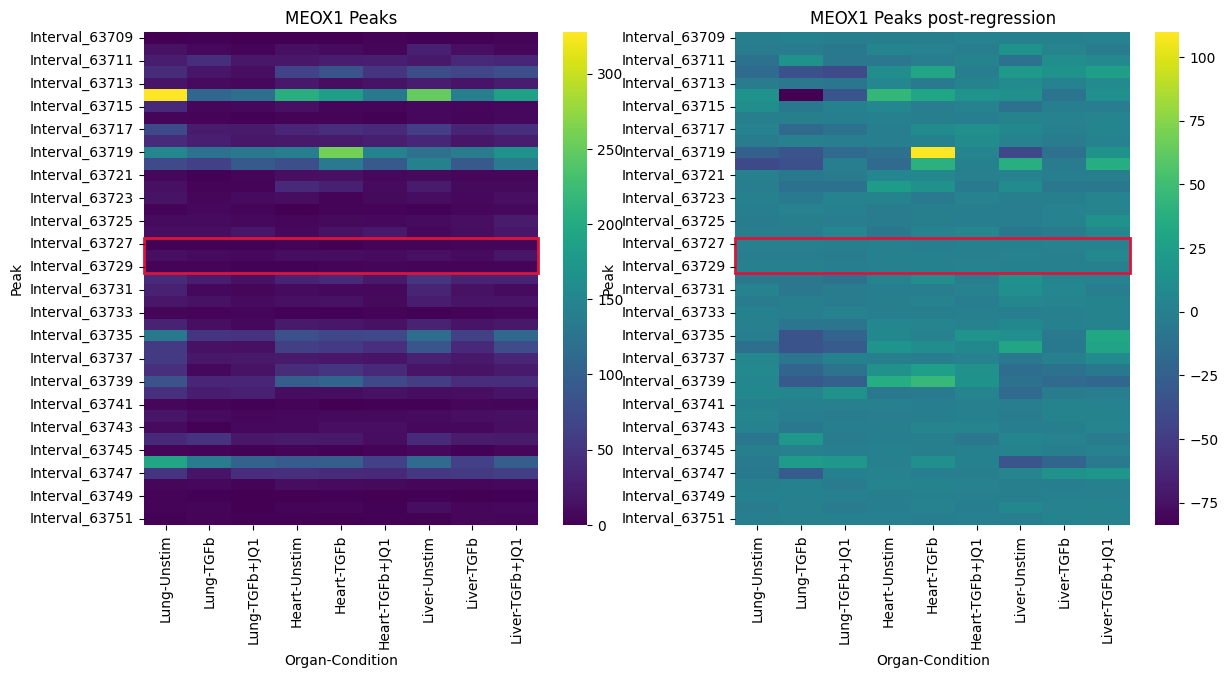

In [33]:
# MEOX1 peaks (Location according to UCSC is chr17, 43.64 - 43.66 Mb, expanding 150kb on either end)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 6.4))
plot_peak_range(atac_adata, chr=17, orf=(43.64, 43.66), ax=ax1)
ax1.set_title("MEOX1 Peaks")
plot_peak_range(atac_adata, chr=17, orf=(43.64, 43.66), ax=ax2, layer='post-regression')
ax2.set_title("MEOX1 Peaks post-regression")
plt.show()

In [44]:
# chr17:43,616,437-43,616,691 <- orthologous to mouse peak 5
# chr17:43,616,835-43,617,184 <- orthologous to mouse peak 5
# not captured in this data
atac_adata[:, ['Interval_63723', 'Interval_63724']].var

,Chr,Start,End,Strand,Length
Geneid,,,,,
Interval_63723,chr17,43614858,43615602,+,745
Interval_63724,chr17,43622133,43622721,+,589


In [36]:
# chr17:43,591,770-43,592,120 <- orthologous to mouse peak 10
# chr17:43,592,215-43,592,517 <- orthologous to mouse peak 9
# 63720 seems to bridge both of these intervals
atac_adata[:, 'Interval_63720'].var

,Chr,Start,End,Strand,Length
Geneid,,,,,
Interval_63720,chr17,43591191,43592816,+,1626


In [50]:
# chr17:43,577,707-43,577,887 <- orthologous to mouse peak 13
# chr17:43,578,079-43,578,427 <- orthologous to mouse peak 13
# chr17:43,578,441-43,578,702 <- orthologous to mouse peak 13
# regions seem to be directly flanking
atac_adata[:, ['Interval_63718', 'Interval_63719']].var

,Chr,Start,End,Strand,Length
Geneid,,,,,
Interval_63718,chr17,43576650,43577072,+,423
Interval_63719,chr17,43578751,43580003,+,1253


In [122]:
# boxplot of peak over organ/condition
def plot_peak(adata: ad.AnnData, peak: str, layer: str = None, **kwargs) -> plt.Axes:
  ax = sns.boxplot(adata.obs, x = 'organ', y = adata[:, peak].to_df(layer = layer).sum(axis = 1), order=markers.keys(), hue = 'condition', palette=palette, hue_order = palette.keys(), **kwargs)
  ax.set_ylabel(f'{peak} consensus peaks {layer if layer is not None else ""}')
  return ax

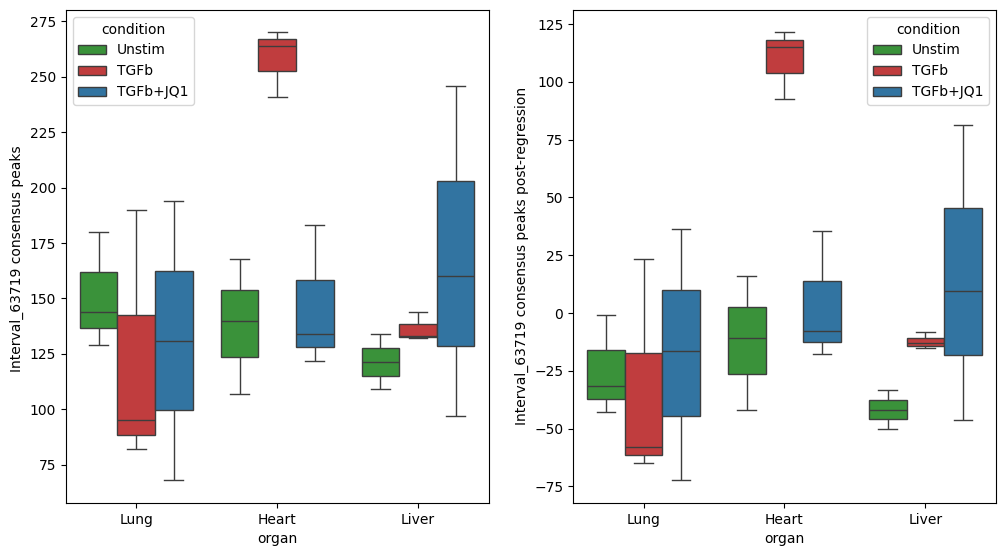

In [123]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = 'Interval_63719', ax=ax1)
plot_peak(atac_adata, peak = 'Interval_63719', ax=ax2, layer = 'post-regression')
plt.show()

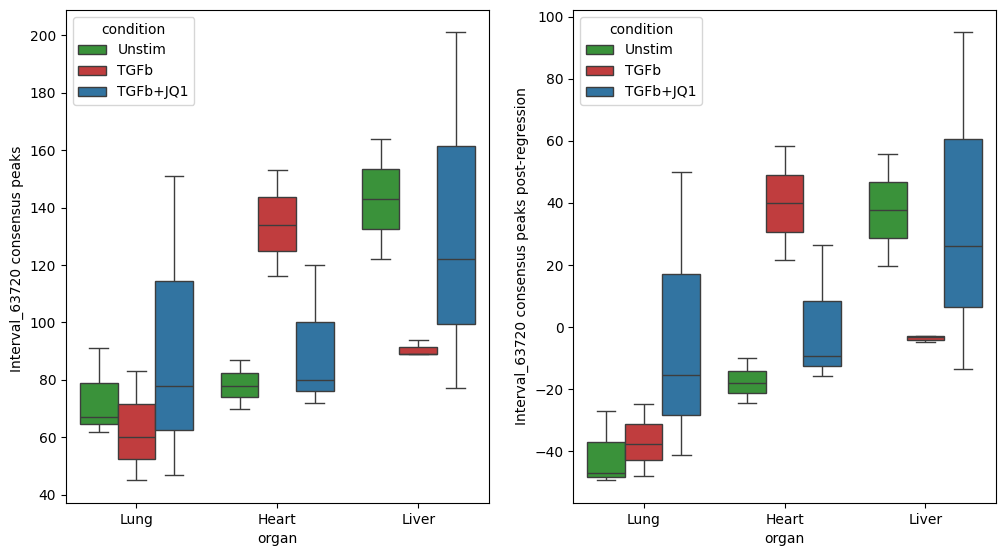

In [124]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = 'Interval_63720', ax=ax1)
plot_peak(atac_adata, peak = 'Interval_63720', ax=ax2, layer = 'post-regression')
plt.show()

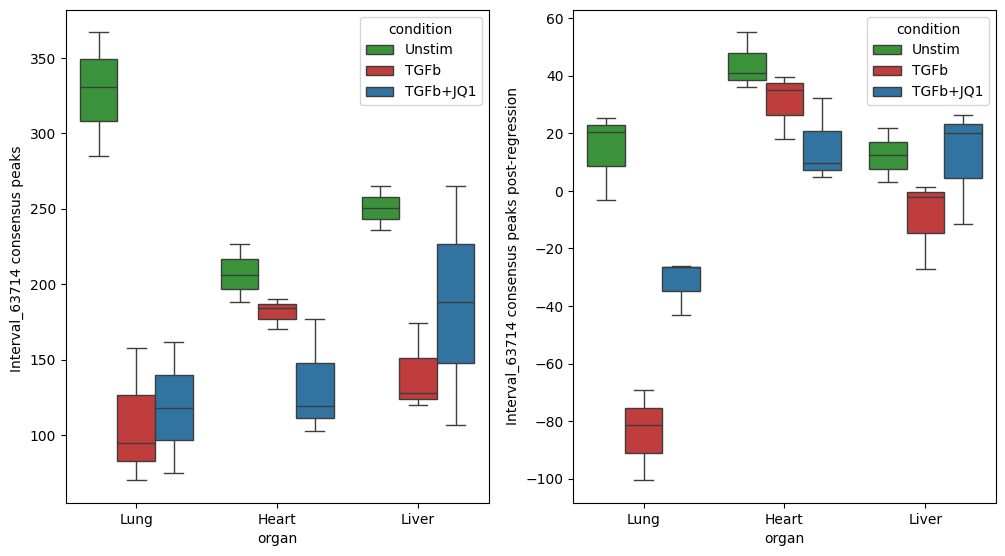

In [125]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = 'Interval_63714', ax=ax1)
plot_peak(atac_adata, peak = 'Interval_63714', ax=ax2, layer = 'post-regression')
plt.show()